# Airbnb Price Prediction

We are using data from Kaggle to predict the log price of an airbnb.

In [54]:
#We Begin by importing the necessary libraries.

import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor 
from collections import Counter
from pdpbox.pdp import pdp_isolate, pdp_plot
from sklearn.metrics import accuracy_score

%matplotlib inline

## Part 1 - Data Exploration

We load in the data from both the train and test dataset. We can see that there are 74111 rows and 29 columns in the set.

In [55]:
airbnb = pd.read_csv("train.csv", low_memory=False)
print(airbnb.shape)

(74111, 30)


In [56]:
#We choose what parts of the data we want to keep.

keeplist = ["instant_bookable", "cancellation_policy", "city", "log_price", "property_type", 
            "room_type", "accommodates", "bathrooms", "cleaning_fee","latitude", "longitude", 
            "number_of_reviews", "review_scores_rating", "bedrooms", "beds", "amenities_count",]
df = airbnb[keeplist].dropna()

In [57]:
# print the information of the dataset
print(df.info())

# print # of rows, # of columns
print(df.shape)

# print the first five rows
df.head()

#We choose what columns we want to use to create our models.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57129 entries, 0 to 74110
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   instant_bookable      57129 non-null  object 
 1   cancellation_policy   57129 non-null  object 
 2   city                  57129 non-null  object 
 3   log_price             57129 non-null  float64
 4   property_type         57129 non-null  object 
 5   room_type             57129 non-null  object 
 6   accommodates          57129 non-null  int64  
 7   bathrooms             57129 non-null  float64
 8   cleaning_fee          57129 non-null  bool   
 9   latitude              57129 non-null  float64
 10  longitude             57129 non-null  float64
 11  number_of_reviews     57129 non-null  int64  
 12  review_scores_rating  57129 non-null  float64
 13  bedrooms              57129 non-null  float64
 14  beds                  57129 non-null  float64
 15  amenities_count    

,instant_bookable,cancellation_policy,city,log_price,property_type,room_type,accommodates,bathrooms,cleaning_fee,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds,amenities_count
0,f,strict,NYC,5.010635,Apartment,Entire home/apt,3,1.0,True,40.696524,-73.991617,2,100.0,1.0,1.0,152
1,t,strict,NYC,5.129899,Apartment,Entire home/apt,7,1.0,True,40.766115,-73.989040,6,93.0,3.0,3.0,218
2,t,moderate,NYC,4.976734,Apartment,Entire home/apt,5,1.0,True,40.808110,-73.943756,10,92.0,1.0,3.0,311
4,t,moderate,DC,4.744932,Apartment,Entire home/apt,2,1.0,True,38.925627,-77.034596,4,40.0,0.0,1.0,174
5,t,strict,SF,4.442651,Apartment,Private room,2,1.0,True,37.753164,-122.429526,3,100.0,1.0,1.0,159


## Part 1.5 - Initial Impressions

### Let's start by looking at City and Room_type

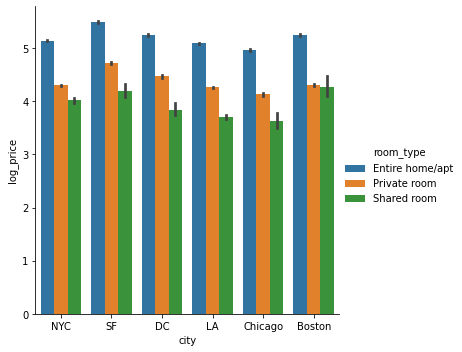

In [152]:
sns.catplot(data=airbnb, kind="bar", x="city", y="log_price", hue="room_type")

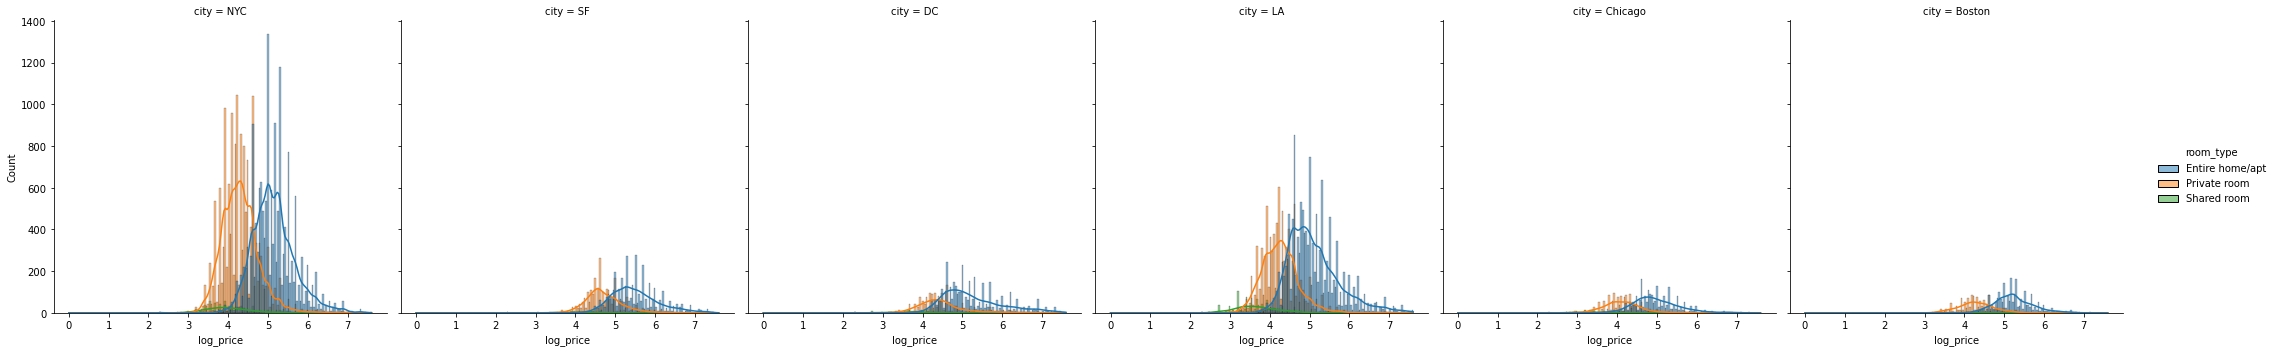

In [157]:
sns.displot(data=airbnb, x="log_price", col="city", hue="room_type", kde=True)

We can again see that the room_type plays a major role in determining price in ever city. We can also see that every city has a major range of prices even if the overall count is low.

### Now let's look at other features to see if they play a role.

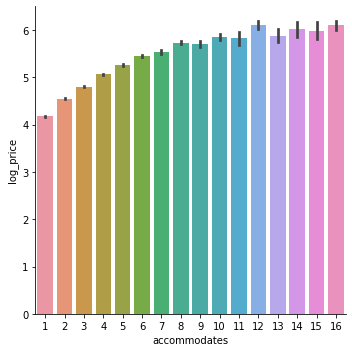

In [178]:
sns.catplot(data=airbnb, kind="bar", x="accommodates", y="log_price")

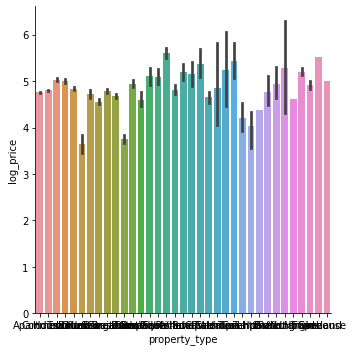

In [179]:
sns.catplot(data=airbnb, kind="bar", x="property_type", y="log_price")

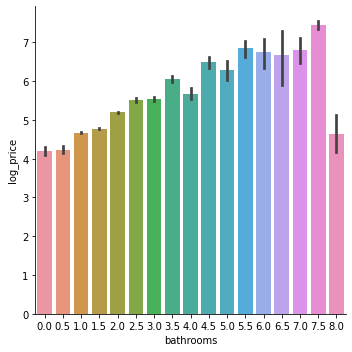

In [180]:
sns.catplot(data=airbnb, kind="bar", x="bathrooms", y="log_price")

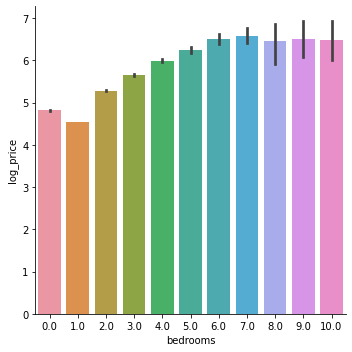

In [184]:
sns.catplot(data=airbnb, kind="bar", x="bedrooms", y="log_price")

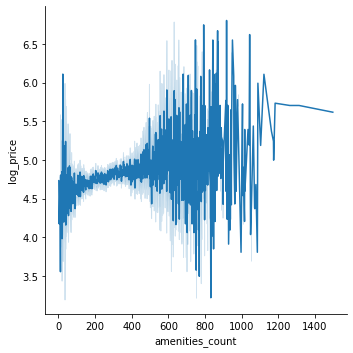

In [189]:
sns.relplot(data=airbnb, kind="line", x="amenities_count", y="log_price")

##### We can see that many features such as accommodates, bathrooms, and bedrooms generally have a positive correlation with price. However, features such as amenitites_count, and property_type have vast differences and error margins. Those features could do more harm than good for the model.

## Part 2 - Data Cleaning

We have to convert certain data types to int to make them fit our model.

In [58]:
#sns.countplot(df.log_price, label="Count")

In [59]:
#We are looking at the room_type column and the data within it.

df['room_type'].value_counts()

Entire home/apt    32900
Private room       22796
Shared room         1433
Name: room_type, dtype: int64

In [60]:
#We assign integer values that the model can use to classify the qualitative data.

df.loc[df["room_type"] == "Entire home/apt", "room_type"] = 0 
df.loc[df["room_type"] == "Private room", "room_type"] = 1
df.loc[df["room_type"] == "Shared room", "room_type"] = 2 

In [61]:
#We continue the same process for property_type.

df['property_type'].value_counts()

Apartment             37567
House                 12989
Condominium            1997
Townhouse              1292
Loft                   1010
Other                   418
Guesthouse              409
Bed & Breakfast         353
Bungalow                307
Villa                   127
Dorm                    105
Guest suite              99
Camper/RV                66
Cabin                    63
In-law                   63
Hostel                   55
Boutique hotel           47
Boat                     46
Timeshare                33
Serviced apartment       15
Tent                     14
Castle                   13
Hut                       7
Treehouse                 6
Vacation home             6
Yurt                      6
Chalet                    5
Tipi                      3
Earth House               3
Train                     2
Cave                      2
Island                    1
Name: property_type, dtype: int64

In [62]:
df.loc[df["property_type"] == "Apartment", "property_type"] = 0 
df.loc[df["property_type"] == "House", "property_type"] = 1
df.loc[df["property_type"] == "Condominium", "property_type"] = 2
df.loc[df["property_type"] == "Townhouse", "property_type"] = 3
df.loc[df["property_type"] == "Loft", "property_type"] = 4
df.loc[df["property_type"] == "Other", "property_type"] = 5
df.loc[df["property_type"] == "Guesthouse", "property_type"] = 6
df.loc[df["property_type"] == "Bed & Breakfast", "property_type"] = 7
df.loc[df["property_type"] == "Bungalow", "property_type"] = 8
df.loc[df["property_type"] == "Villa", "property_type"] = 9
df.loc[df["property_type"] == "Dorm", "property_type"] = 10
df.loc[df["property_type"] == "Guest suite", "property_type"] = 11
df.loc[df["property_type"] == "Camper/RV", "property_type"] = 12
df.loc[df["property_type"] == "Cabin", "property_type"] = 13
df.loc[df["property_type"] == "In-law", "property_type"] = 14
df.loc[df["property_type"] == "Hostel", "property_type"] = 15
df.loc[df["property_type"] == "Boutique hotel", "property_type"] = 16
df.loc[df["property_type"] == "Boat", "property_type"] = 17
df.loc[df["property_type"] == "Timeshare", "property_type"] = 18
df.loc[df["property_type"] == "Serviced apartment", "property_type"] = 19
df.loc[df["property_type"] == "Tent", "property_type"] = 20
df.loc[df["property_type"] == "Castle", "property_type"] = 21
df.loc[df["property_type"] == "Hut", "property_type"] = 22
df.loc[df["property_type"] == "Treehouse", "property_type"] = 23
df.loc[df["property_type"] == "Vacation home", "property_type"] = 24
df.loc[df["property_type"] == "Yurt", "property_type"] = 25
df.loc[df["property_type"] == "Chalet", "property_type"] = 26
df.loc[df["property_type"] == "Tipi", "property_type"] = 27
df.loc[df["property_type"] == "Earth House", "property_type"] = 28
df.loc[df["property_type"] == "Train", "property_type"] = 29
df.loc[df["property_type"] == "Cave", "property_type"] = 30
df.loc[df["property_type"] == "Island", "property_type"] = 31

In [63]:
#We continue the same process for city.

df['city'].value_counts()

NYC        24887
LA         17114
SF          5029
DC          4084
Chicago     3204
Boston      2811
Name: city, dtype: int64

In [64]:
df.loc[df["city"] == "NYC", "city"] = 0 
df.loc[df["city"] == "LA", "city"] = 1
df.loc[df["city"] == "SF", "city"] = 2 
df.loc[df["city"] == "DC", "city"] = 3 
df.loc[df["city"] == "Chicago", "city"] = 4
df.loc[df["city"] == "Boston", "city"] = 5

In [65]:
#We continue the same process for cancellation_policy

df['cancellation_policy'].value_counts()

strict             27681
moderate           16432
flexible           12928
super_strict_30       78
super_strict_60       10
Name: cancellation_policy, dtype: int64

In [66]:
df.loc[df["cancellation_policy"] == "strict", "cancellation_policy"] = 0 
df.loc[df["cancellation_policy"] == "moderate", "cancellation_policy"] = 1
df.loc[df["cancellation_policy"] == "flexible", "cancellation_policy"] = 2 
df.loc[df["cancellation_policy"] == "super_strict_30", "cancellation_policy"] = 3 
df.loc[df["cancellation_policy"] == "super_strict_60", "cancellation_policy"] = 4

In [67]:
#We continue the same process for instant_bookable

df['instant_bookable'].value_counts()

f    41790
t    15339
Name: instant_bookable, dtype: int64

In [68]:
df.loc[df["instant_bookable"] == "t", "instant_bookable"] = 0 
df.loc[df["instant_bookable"] == "f", "instant_bookable"] = 1

## Part 3 - Running Models

In this part, we partition our data and actually create the models.

In [69]:
# split the dataset for cross validation

x_columns = ["room_type", "latitude", "longitude", "bathrooms", 
             "bedrooms", "accommodates", "beds", "amenities_count",]

y = df['log_price']
X = df[x_columns]
X_train, X_test, y_train, y_test = train_test_split (X, y, train_size = 0.85, random_state = 1)

In [70]:
#We run a linear regression model.

reg = LinearRegression() 
reg.fit(X_train, y_train)
print(reg.score(X_test, y_test))

0.5765012099578427


In [96]:
#We run a random forest regressor model.

forest_reg = RandomForestRegressor(random_state=1) 
forest_reg.fit(X_train, y_train) 

print(forest_reg.score(X_test, y_test))

0.7311830636499247


In [72]:
#We run a boosting model.

gb = GradientBoostingRegressor() 
gb.fit(X_train, y_train) 
print(gb.score(X_test, y_test))

0.713251368004342


## Part 4 - Data Analysis

In this part, we look at our best model and try to understand what factors it uses to determine Airbnb prices.

In [117]:
#We can use this to predict the logprice of an Airbnb using our model.
#The inputs are as follows: room_type, latitude, longitude, bathrooms, bedrooms, accomodates, beds, amenities_count.

linear_reg_pred = reg.predict([[1, 41, -74, 2, 2, 4, 2, 120]])
forest_reg_pred = forest_reg.predict([[1, 41, -74, 2, 2, 4, 2, 120]])
gb_pred = gb.predict([[1, 41, -74, 2, 2, 4, 2, 120]])

print("Predicted Log Price using Linear Regression: %f"% linear_reg_pred)
print("Predicted Log Price using Forest Regressor: %f"% forest_reg_pred)
print("Predicted Log Price using Boosting Regressor: %f"% gb_pred)

Predicted Log Price using Linear Regression: 4.667560
Predicted Log Price using Forest Regressor: 4.510715
Predicted Log Price using Boosting Regressor: 4.626820


In [74]:
#We take our best model and look at the error scores.

# print out the RMSE score 
from sklearn.metrics import mean_squared_error, mean_absolute_error 
 
y_pred_tree = forest_reg.predict(X_test) 
tree_mse = mean_squared_error(y_pred_tree, y_test) 
tree_rmse = np.sqrt(tree_mse) 
print('Decision Tree RMSE: %.4f' % tree_rmse) 
 
# Calculate mean absolute error (MAE) 
tree_mae = mean_absolute_error(y_pred_tree, y_test) 
print('Decision Tree MAE: %.4f' % tree_mae) 
 
# print R-squared value 
print("R-squared", r2_score(y_test, y_pred_tree)) 

Decision Tree RMSE: 0.3473
Decision Tree MAE: 0.2580
R-squared 0.7301530550671351


No handles with labels found to put in legend.


room_type          0.410624
longitude          0.164066
latitude           0.147953
bathrooms          0.124593
amenities_count    0.070355
accommodates       0.035238
bedrooms           0.035196
beds               0.011976
dtype: float64


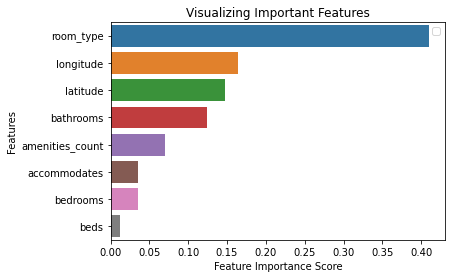

In [75]:
#We take our best model and look at the factors that were the most important in determining the Airbnb prices.

feature_imp = pd.Series(forest_reg.feature_importances_,index=x_columns).sort_values(ascending=False)
print(feature_imp)

%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

We can see that our most important features are the room type, location, and bathrooms. We knew that this was going to be the case from our Initial Impressions section. We can also see that we have chose to omit property_type because it did in fact make the model worse.

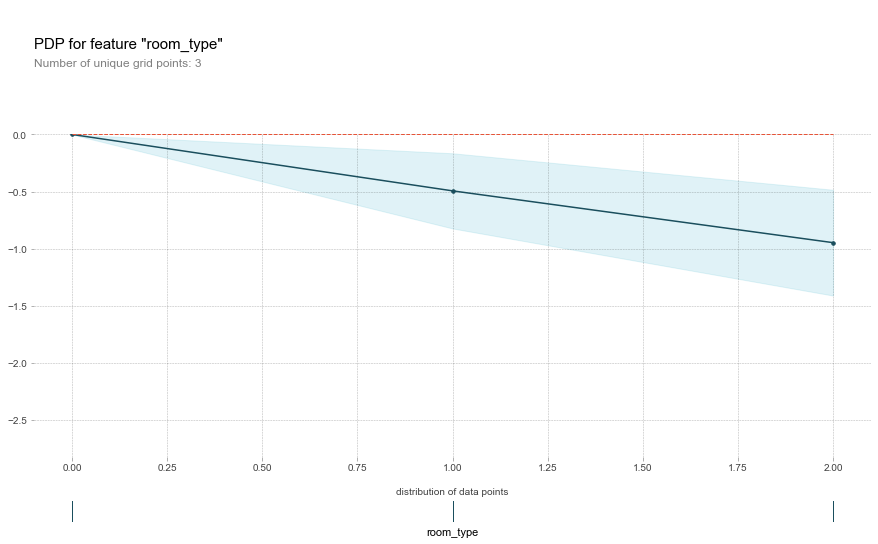

In [204]:
pdp_room_type = pdp_isolate(model=forest_reg, dataset=df, model_features=x_columns,feature='room_type')
fig, axes = pdp_plot(pdp_isolate_out=pdp_room_type,feature_name='room_type',plot_pts_dist=True)

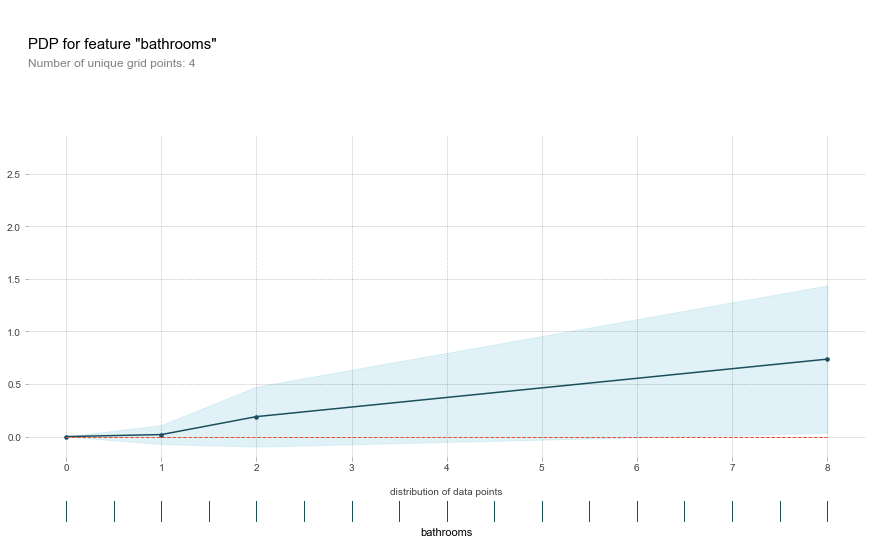

In [207]:
pdp_bathrooms = pdp_isolate(model=forest_reg, dataset=df, model_features=x_columns,feature='bathrooms')
fig, axes = pdp_plot(pdp_isolate_out=pdp_bathrooms,feature_name='bathrooms',plot_pts_dist=True)

These two PDP Plots show how much of an impact bathrooms and room_type affect Airbnb pricing. 

## Conclusion

Ultimately, we were able to create a random forest regressor model that could predict Airbnb prices with 70+ percent accuracy. While 70% might not seem impressive on paper, it is important to understand that Airbnb prices are determined by house owners who could be upcharging or downcharging. So, reaching this level of confidence can be considered a success. 